In [67]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from statistics import mode
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [68]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/V_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]

,label,cycle number,Capacity/mA.h,Norm_Cap,Cycles Until Fail,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,EIS_PCA_1,EIS_PCA_2,category,temperature
0,25C01,2,37.202713,1.0,234,0.38470,0.39156,0.39684,0.40341,0.40963,...,0.15473,0.18024,0.21535,0.25411,0.29026,0.32795,-0.648439,0.135808,1.0,25.0
261,25C02,2,35.060836,1.0,12,0.27315,0.28005,0.28916,0.29896,0.31009,...,0.16948,0.19432,0.23012,0.27316,0.31468,0.35528,0.997356,-0.606846,0.0,25.0
442,25C03,2,36.771703,1.0,164,0.26859,0.27977,0.28738,0.29862,0.31003,...,0.18334,0.21595,0.25083,0.28522,0.32480,0.37723,1.561054,-0.809891,0.0,25.0
644,25C04,2,35.534219,1.0,114,0.26546,0.27469,0.28046,0.29147,0.30112,...,0.18886,0.21123,0.24230,0.28393,0.32850,0.37336,1.061945,-0.751243,0.0,25.0
679,25C05,2,37.210831,1.0,152,0.34630,0.35399,0.35952,0.36615,0.37339,...,0.15592,0.17752,0.20654,0.23916,0.27151,0.31109,-1.097987,-0.006821,0.0,25.0
954,25C06,2,35.992184,1.0,120,0.29226,0.29988,0.30750,0.31758,0.32662,...,0.17112,0.19462,0.22959,0.27546,0.32275,0.36648,0.706666,-0.459589,0.0,25.0
1166,25C07,2,35.684646,1.0,32,0.30065,0.30717,0.31678,0.32634,0.33815,...,0.17637,0.20248,0.24127,0.28804,0.33312,0.37771,1.237057,-0.580435,0.0,25.0
1306,25C08,2,33.943672,1.0,32,0.28914,0.29589,0.30454,0.31619,0.32735,...,0.18095,0.20767,0.24267,0.28048,0.32001,0.37131,1.384369,-0.730253,0.0,25.0
1343,35C01,2,40.113305,1.0,218,0.27500,0.28167,0.28649,0.29203,0.29889,...,0.14148,0.15970,0.18417,0.21406,0.24424,0.27584,-2.642164,-0.091726,1.0,35.0
1670,35C02,2,40.473768,1.0,262,0.47084,0.47585,0.48147,0.48775,0.49372,...,0.13944,0.15736,0.18120,0.21156,0.24130,0.27295,-1.313667,0.634642,1.0,35.0


In [69]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

#Generate a dataframe with the first 40 cycles only
df_40 = df[(df['cycle number']<=40)]

In [70]:
#Get the EIS part of the df only so that we can do PCA.
EIS_Only_df_20 = df_20[df_20.columns.to_list()[5:125]]
#Scale the features
scaled_features = StandardScaler().fit_transform(EIS_Only_df_20.values)
Scaled_EIS = pd.DataFrame(scaled_features, index=EIS_Only_df_20.index, columns=EIS_Only_df_20.columns)
#Define the PCA
pca = PCA(2)
#Perform the PCA fit and transform the features into that reduced dimensional space
principalComponents = pca.fit_transform(Scaled_EIS)
print(pca.n_components_)
#Put it into a pandas df
Reduced_df = pd.DataFrame(data = principalComponents,columns=['PCA1','PCA2'])

2


In [71]:
print(pca.explained_variance_ratio_)

[0.59527351 0.39187258]


In [72]:
pca.components_

array([[ 0.06881626,  0.0684889 ,  0.06813574,  0.06762803,  0.06707932,
         0.066459  ,  0.06576248,  0.06495238,  0.06406791,  0.06312201,
         0.06205605,  0.06082654,  0.05948967,  0.05795685,  0.05632124,
         0.05446544,  0.0524089 ,  0.05010089,  0.0476851 ,  0.04492674,
         0.04182099,  0.03842517,  0.03480315,  0.03090212,  0.0269624 ,
         0.02281316,  0.01859193,  0.01433317,  0.0095947 ,  0.00418137,
        -0.00197194, -0.00912891, -0.01681042, -0.02474114, -0.03240215,
        -0.03935069, -0.0451464 , -0.05003   , -0.0538072 , -0.05667728,
        -0.05879906, -0.06041479, -0.06169839, -0.06265437, -0.06344989,
        -0.06408478, -0.06466604, -0.06514995, -0.06553142, -0.06586766,
        -0.06620375, -0.06657066, -0.06689357, -0.06717126, -0.06750917,
        -0.06799101, -0.0687096 , -0.06947781, -0.07029493, -0.07146674,
        -0.10863567, -0.11342671, -0.11591458, -0.11691463, -0.11736   ,
        -0.11752058, -0.11753964, -0.11757267, -0.1

In [73]:
Reduced_df['Cycles Until Fail']=df_20['Cycles Until Fail'].reset_index(drop=True)
Reduced_df['label']=df_20['label'].reset_index(drop=True)
Reduced_df['category']=df_20['category'].reset_index(drop=True)
Reduced_df['temperature']=df_20['temperature'].reset_index(drop=True)
Reduced_df

,PCA1,PCA2,Cycles Until Fail,label,category,temperature
0,3.869399,-3.429028,234,25C01,1.0,25.0
1,3.624190,-3.245927,232,25C01,1.0,25.0
2,3.527507,-3.165604,230,25C01,1.0,25.0
3,3.357923,-3.062763,228,25C01,1.0,25.0
4,3.359983,-3.007417,226,25C01,1.0,25.0
...,...,...,...,...,...,...
115,11.776241,-4.502916,378,45C02,1.0,45.0
116,11.765430,-4.349192,376,45C02,1.0,45.0
117,11.765589,-4.464694,374,45C02,1.0,45.0
118,11.767809,-5.069436,372,45C02,1.0,45.0


In [74]:
df_20['Cycles Until Fail'].reset_index(drop=True)

0      234
1      232
2      230
3      228
4      226
      ... 
115    378
116    376
117    374
118    372
119    370
Name: Cycles Until Fail, Length: 120, dtype: int64

In [75]:
df_20['Cycles Until Fail']

0       234
1       232
2       230
3       228
4       226
       ... 
2292    378
2293    376
2294    374
2295    372
2296    370
Name: Cycles Until Fail, Length: 120, dtype: int64

In [76]:
Reduced_df['label'].unique()

array(['25C01', '25C02', '25C03', '25C04', '25C05', '25C06', '25C07',
       '25C08', '35C01', '35C02', '45C01', '45C02'], dtype=object)

In [85]:
Scaled_EIS['Cycles Until Fail']=df_20['Cycles Until Fail']
Scaled_EIS['label']=df_20['label']
Scaled_EIS['category']=df_20['category']
Scaled_EIS['temperature']=df_20['temperature']
Scaled_EIS

,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,6217.2461 Re,4905.291 Re,3881.2737 Re,3070.9827 Re,2430.7778 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,Cycles Until Fail,label,category,temperature
0,-0.162363,-0.162238,-0.168923,-0.173523,-0.181282,-0.180465,-0.186809,-0.196958,-0.203036,-0.204805,...,-0.424368,-0.307784,-0.085478,0.037912,-0.006072,-0.101449,234,25C01,1.0,25.0
1,-0.149611,-0.156490,-0.157147,-0.159382,-0.165477,-0.171573,-0.176678,-0.181129,-0.186034,-0.195191,...,-0.244848,-0.242707,-0.156394,-0.148728,-0.219721,-0.195784,232,25C01,1.0,25.0
2,-0.144951,-0.148590,-0.151474,-0.157031,-0.160975,-0.164959,-0.176584,-0.174034,-0.183497,-0.187237,...,0.000944,-0.034163,-0.163328,-0.146891,-0.062260,-0.070956,230,25C01,1.0,25.0
3,-0.140169,-0.147268,-0.146665,-0.151306,-0.157187,-0.162213,-0.165418,-0.173340,-0.178992,-0.178166,...,-0.228909,-0.237900,-0.069088,0.124539,0.158717,0.065877,228,25C01,1.0,25.0
4,-0.139219,-0.143672,-0.142534,-0.150409,-0.150107,-0.157907,-0.158518,-0.169146,-0.177089,-0.177144,...,-0.152571,-0.138065,-0.062154,-0.074177,-0.145988,-0.145853,226,25C01,1.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,0.284110,0.274462,0.275958,0.263306,0.257443,0.246381,0.237768,0.224142,0.211291,0.189388,...,-1.288413,-1.299478,-1.426584,-1.473062,-1.439649,-1.433959,378,45C02,1.0,45.0
2293,0.298241,0.290292,0.290016,0.281934,0.270360,0.262511,0.249937,0.237985,0.224677,0.211524,...,-1.340843,-1.478072,-1.471025,-1.439199,-1.440094,-1.553260,376,45C02,1.0,45.0
2294,0.285704,0.281163,0.277253,0.261202,0.255828,0.245071,0.240622,0.221209,0.204661,0.196671,...,-1.461222,-1.484727,-1.467243,-1.480675,-1.548028,-1.517812,374,45C02,1.0,45.0
2295,0.210878,0.211479,0.205916,0.191239,0.186056,0.173748,0.164690,0.149407,0.137447,0.119499,...,-1.414245,-1.477332,-1.440767,-1.477000,-1.534259,-1.553831,372,45C02,1.0,45.0


In [86]:
#Functions to run Lasso and generate plots. 
def run_Classification_ML(df,Train_L,Test_L,feats,model):
    feature_names=feats
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[df['label'] == Label]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feature_names]
    y_train = train_df['category']
    
    test_df = pd.DataFrame(columns = df.columns)
    for Label in Test_L:
        #Get the correct train test splits. 
        selected_rows = df[df['label'] == Label]
        test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feature_names]
    y_test = test_df['category']
    #Running the Model
    clf = model
    clf.fit(X_train, y_train)
    clf_pred=clf.predict(X_test)   
    return y_test.to_list(),clf_pred,clf
        
    
def Train_Regr_ML(df,Train_L,model,feats):
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[(df['label'] == Label)]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feats]
    y_train = train_df['Cycles Until Fail']
    
    #Running the Model
    regr = model
    regr.fit(X_train, y_train)
    
    #Return the trained model.
    return regr
    
#For testing batteries one at a time. 
def Test_Regr_Model(df,Test_Label,regr,feats):
    test_df = pd.DataFrame(columns = df.columns)
    selected_rows = df[(df['label'] == Test_Label)]
    test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feats]
    y_test = test_df['Cycles Until Fail']
    #Convert y_test to numpy and rename
    true_C=y_test.to_numpy() 
    
    #Predict using the trained model
    regr_pred=regr.predict(X_test)
    
    #Return the predictions and the true values
    return regr_pred,true_C
    
def add_cycling(Pred,TruC):
    TotalP=[]
    TotalT=[]
    for i in range(len(Pred)):
        LP=np.arange(Pred[i],0,-1)
        LT=np.arange(TruC[i],TruC[i]-len(LP),-1)
        TotalP.append(LP)
        TotalT.append(LT)
    return TotalP,TotalT
        
    
def make_Cycling_Plots(Pred,TruC,label):
    title_string=str(label)+'Predicted Cycle to Failure vs True Cycles to Failure'
    TotalP,TotalT=add_cycling(Pred,TruC)
    xref=np.arange(0,TotalT[0][0],1)
    cerr=np.arange(0,len(TotalP),1)
    N=len(TotalP)
    cmap=plt.get_cmap('viridis',N)
    for i in range(len(TotalP)):
        plt.plot(TotalT[i],TotalP[i],c=cmap(i),alpha=0.8,linewidth=3.0)
    norm=mpl.colors.Normalize(vmin=2,vmax=2*len(TotalP))
    sm=plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))
    cbar.set_label('Index')
    plt.plot(xref,xref,'k',linestyle='dashed',linewidth=3)
    plt.title(title_string)
    plt.xlabel('True # of Cycles until Failure')
    plt.ylabel('Predicted # of Cycles until Failure')
    plt.show()
    

['PCA1' 'PCA2']
[11.47803223  5.30017248]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 184.01745607879622
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


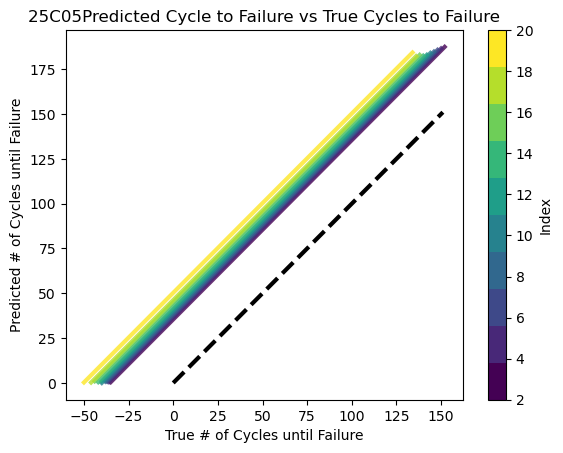

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 98.65454505485036
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


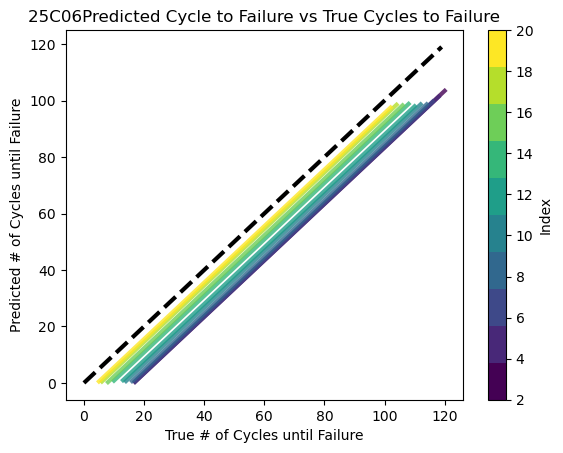

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 62.615071671074446
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


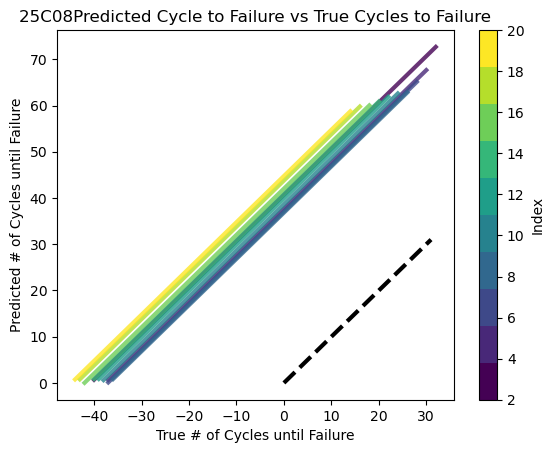

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 235.96628075013825
The True RuL at Cycle 10 is: 254


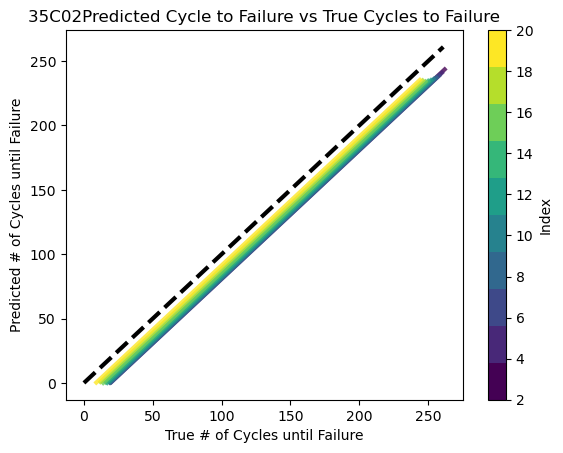

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 277.0876890178267
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


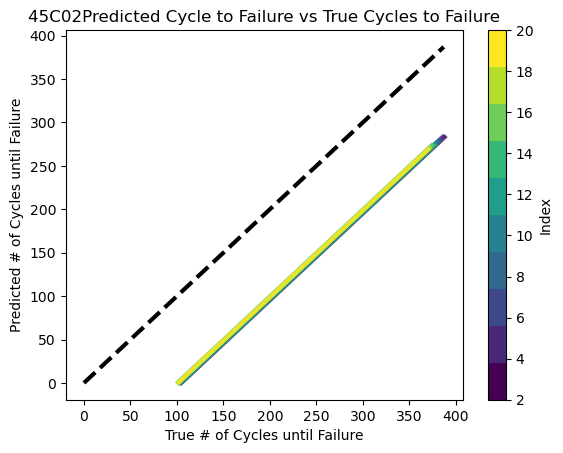

In [87]:
###
### First 40 cycles
### 20kHz and 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['PCA1','PCA2']
mydf=Reduced_df

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

In [98]:
Scaled_EIS.columns.to_list()[60:120]

['20004.453 Im',
 '15829.126 Im',
 '12516.703 Im',
 '9909.4424 Im',
 '7835.48 Im',
 '6217.2461 Im',
 '4905.291 Im',
 '3881.2737 Im',
 '3070.9827 Im',
 '2430.7778 Im',
 '1923.1537 Im',
 '1522.4358 Im',
 '1203.8446 Im',
 '952.86591 Im',
 '754.27557 Im',
 '596.71857 Im',
 '471.96338 Im',
 '373.20856 Im',
 '295.47278 Im',
 '233.87738 Im',
 '185.05922 Im',
 '146.35823 Im',
 '115.77804 Im',
 '91.6721 Im',
 '72.51701 Im',
 '57.36816 Im',
 '45.3629 Im',
 '35.93134 Im',
 '28.40909 Im',
 '22.48202 Im',
 '17.79613 Im',
 '14.06813 Im',
 '11.1448 Im',
 '8.81772 Im',
 '6.97545 Im',
 '5.5173 Im',
 '4.36941 Im',
 '3.45686 Im',
 '2.73547 Im',
 '2.16054 Im',
 '1.70952 Im',
 '1.35352 Im',
 '1.07079 Im',
 '0.84734 Im',
 '0.67072 Im',
 '0.53067 Im',
 '0.41976 Im',
 '0.33183 Im',
 '0.26261 Im',
 '0.20791 Im',
 '0.16452 Im',
 '0.13007 Im',
 '0.10309 Im',
 '0.08153 Im',
 '0.06443 Im',
 '0.05102 Im',
 '0.04042 Im',
 '0.03192 Im',
 '0.02528 Im',
 '0.01999 Im']

['20004.453 Im' '15829.126 Im' '12516.703 Im' '9909.4424 Im' '7835.48 Im'
 '6217.2461 Im' '4905.291 Im' '3881.2737 Im' '3070.9827 Im' '2430.7778 Im'
 '1923.1537 Im' '1522.4358 Im' '1203.8446 Im' '952.86591 Im'
 '754.27557 Im' '596.71857 Im' '471.96338 Im' '373.20856 Im'
 '295.47278 Im' '233.87738 Im' '185.05922 Im' '146.35823 Im'
 '115.77804 Im' '91.6721 Im' '72.51701 Im' '57.36816 Im' '45.3629 Im'
 '35.93134 Im' '28.40909 Im' '22.48202 Im' '17.79613 Im' '14.06813 Im'
 '11.1448 Im' '8.81772 Im' '6.97545 Im' '5.5173 Im' '4.36941 Im'
 '3.45686 Im' '2.73547 Im' '2.16054 Im' '1.70952 Im' '1.35352 Im'
 '1.07079 Im' '0.84734 Im' '0.67072 Im' '0.53067 Im' '0.41976 Im'
 '0.33183 Im' '0.26261 Im' '0.20791 Im' '0.16452 Im' '0.13007 Im'
 '0.10309 Im' '0.08153 Im' '0.06443 Im' '0.05102 Im' '0.04042 Im'
 '0.03192 Im' '0.02528 Im' '0.01999 Im' 'temperature']
[-22.66640616  -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.         

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


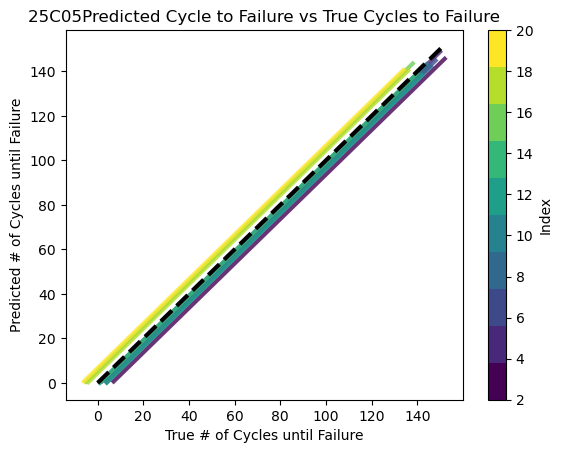

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 77.4635635595584
The True RuL at Cycle 10 is: 112


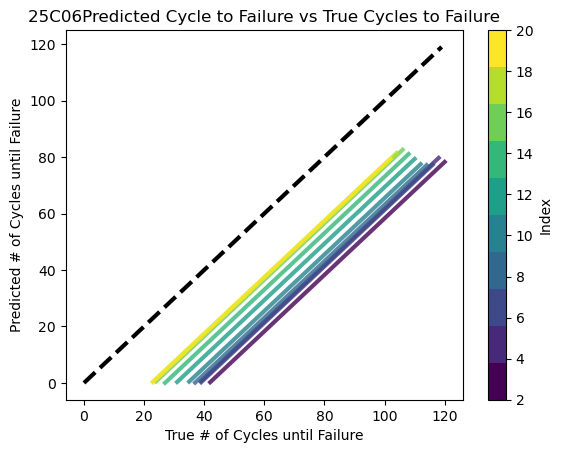

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 71.41617724527285
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


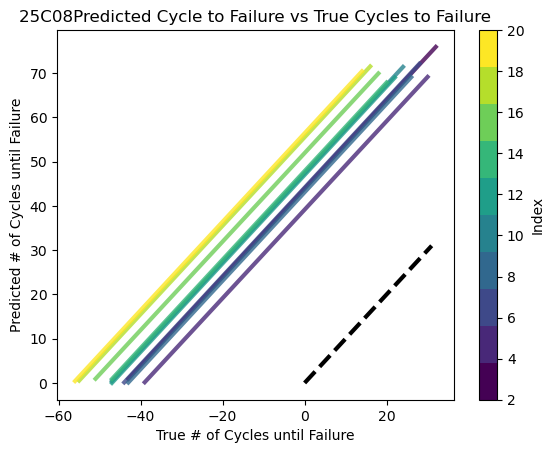

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 247.90374459746835
The True RuL at Cycle 10 is: 254


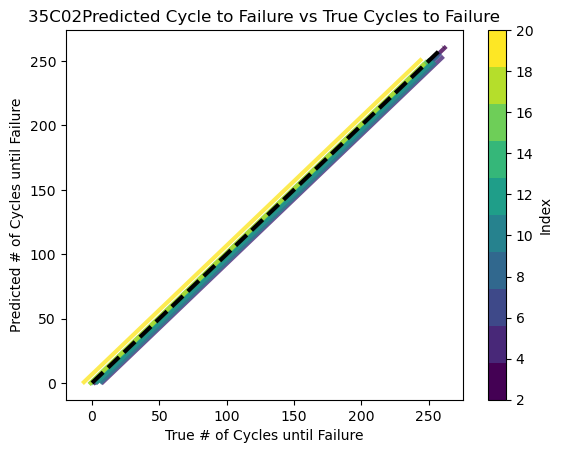

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 376.61610888874753
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


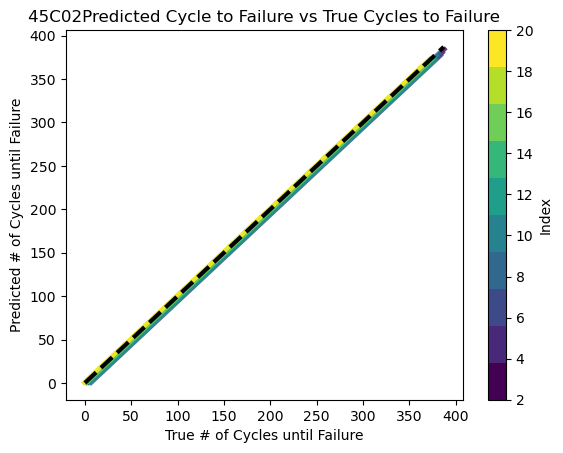

In [101]:
###
### First 40 cycles
### 20kHz and 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=Scaled_EIS.columns.to_list()[60:120]+['temperature']
mydf=Scaled_EIS

model = Lasso(alpha=8,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['20004.453 Im' '8.81772 Im' 'temperature']
[-47.51709965   0.          10.27554954]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 126.99091924794135
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


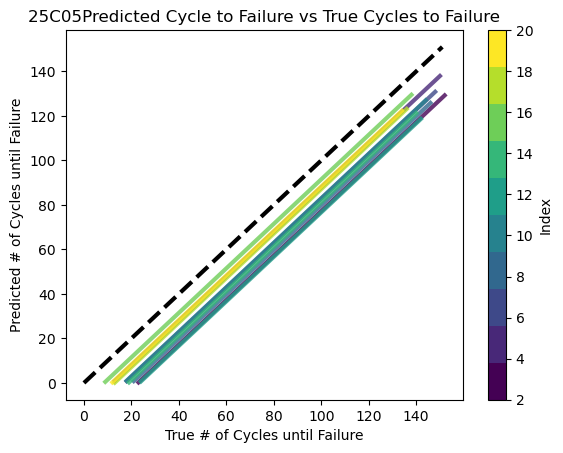

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 63.807439363363244
The True RuL at Cycle 10 is: 112


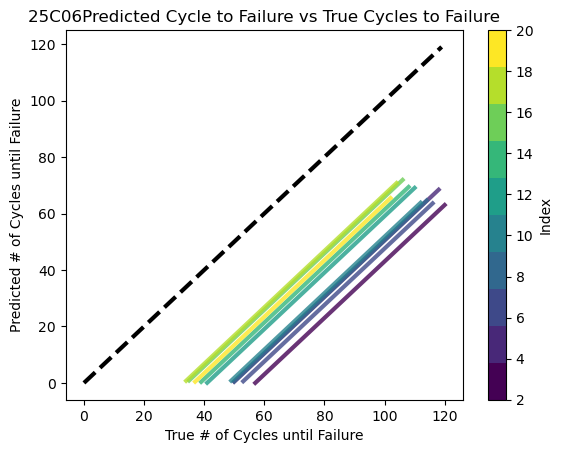

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C08 The Predicted RuL at Cycle 10 is: 57.53691738995681
The True RuL at Cycle 10 is: 24


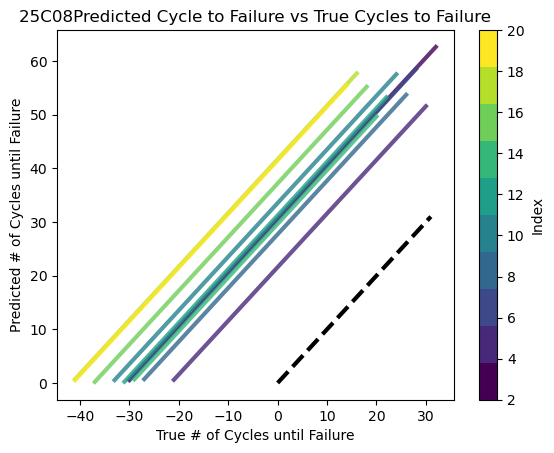

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 226.87685378307526
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


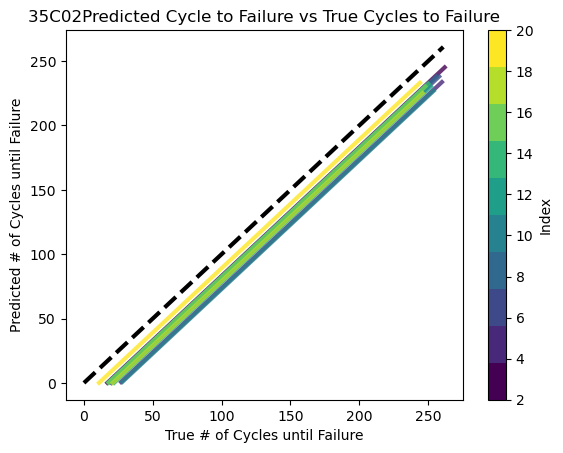

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 383.1443460621431
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_32996/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


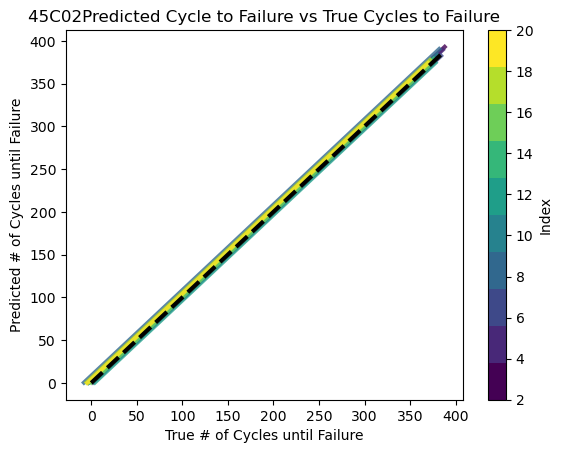

In [110]:
###
### First 40 cycles
### 20kHz and 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','8.81772 Im','temperature']
mydf=Scaled_EIS

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

In [111]:
def run_Classification_ML(df,Train_L,Test_L,feats,model):
    feature_names=feats
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[df['label'] == Label]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feature_names]
    y_train = train_df['category']
    
    test_df = pd.DataFrame(columns = df.columns)
    for Label in Test_L:
        #Get the correct train test splits. 
        selected_rows = df[df['label'] == Label]
        test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feature_names]
    y_test = test_df['category']
    #Running the Model
    clf = model
    clf.fit(X_train, y_train)
    clf_pred=clf.predict(X_test)   
    return y_test.to_list(),clf_pred,clf
        
    
def Train_Regr_ML(df,Train_L,model,feats):
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[(df['label'] == Label)]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feats]
    y_train = train_df['Cycles Until Fail']
    
    #Running the Model
    regr = model
    regr.fit(X_train, y_train)
    
    #Return the trained model.
    return regr
    
#For testing batteries one at a time. 
def Test_Regr_Model(df,Test_Label,regr,feats):
    test_df = pd.DataFrame(columns = df.columns)
    selected_rows = df[(df['label'] == Test_Label)]
    test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feats]
    y_test = test_df['Cycles Until Fail']
    #Convert y_test to numpy and rename
    true_C=y_test.to_numpy() 
    
    #Predict using the trained model
    regr_pred=regr.predict(X_test)
    
    #Return the predictions and the true values
    return regr_pred,true_C
    
def add_cycling(Pred,TruC):
    TotalP=[]
    TotalT=[]
    for i in range(len(Pred)):
        LP=np.arange(Pred[i],0,-1)
        LT=np.arange(TruC[i],TruC[i]-len(LP),-1)
        TotalP.append(LP)
        TotalT.append(LT)
    return TotalP,TotalT
        
    
def make_Cycling_Plots(Pred,TruC,label):
    title_string=str(label)+'Predicted Cycle to Failure vs True Cycles to Failure'
    TotalP,TotalT=add_cycling(Pred,TruC)
    xref=np.arange(0,TotalT[0][0],1)
    plt.plot(xref,xref,'k',linestyle='dashed',linewidth=3)
    for i in range(len(TotalP)):
        plt.plot(TotalT[i],TotalP[i],c='b',alpha=0.4,linewidth=3.0)
    plt.title(title_string)
    plt.xlabel('True # of Cycles until Failure')
    plt.ylabel('Predicted # of Cycles until Failure')
    plt.show()
    

In [7]:
###
### First 40 cycles
###
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','8.81772 Im','temperature']
mydf=df_40

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

['20004.453 Im' '8.81772 Im' 'temperature']
[-524.16664556 -480.26010208    9.15610291]


For Batterty 25C05 The Predicted RuL at Cycle 10 is: 137.82625365641292
The True RuL at Cycle 10 is: 144


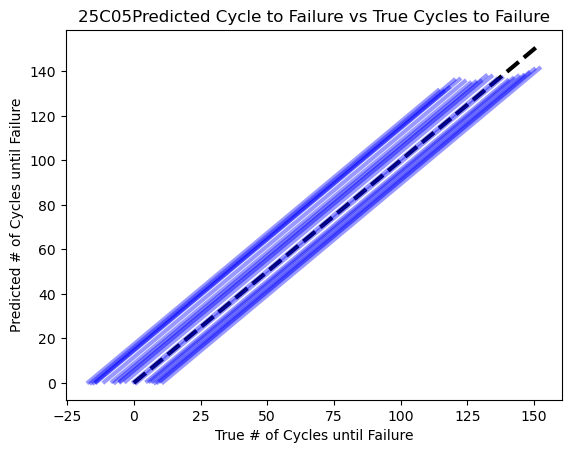

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 86.4398574433304
The True RuL at Cycle 10 is: 112


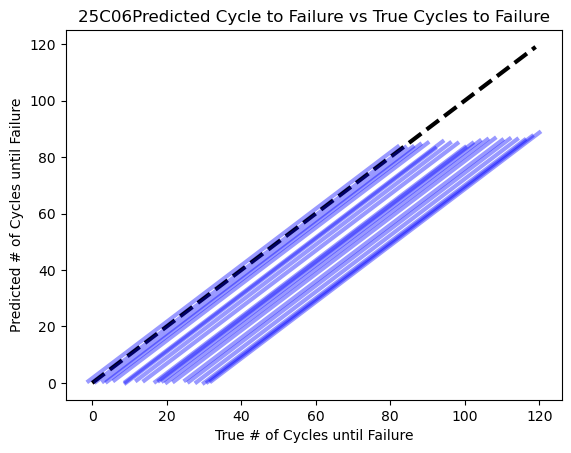

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 55.70903240125372
The True RuL at Cycle 10 is: 24


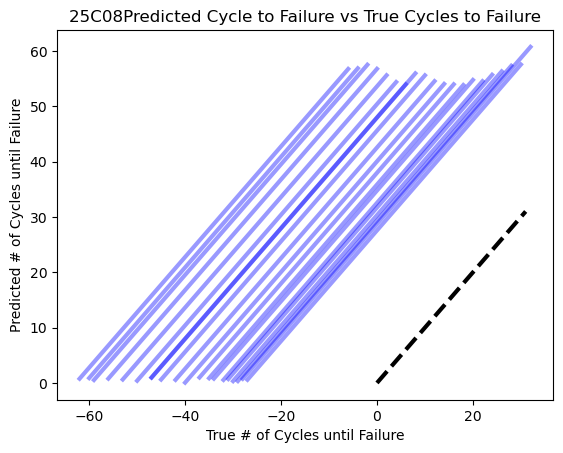

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 256.75760944399866
The True RuL at Cycle 10 is: 254


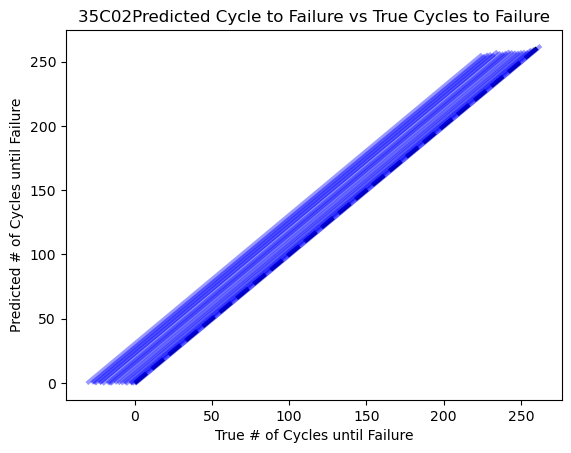

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 366.09336451934024
The True RuL at Cycle 10 is: 380


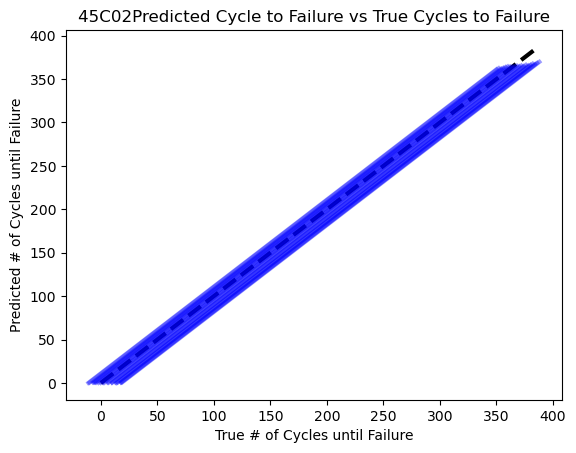

In [8]:
for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

In [9]:
###
### First 40 cycles
### Only 20kHz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','temperature']
mydf=df_40

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

['20004.453 Im' 'temperature']
[-3437.94176496    12.09627513]


For Batterty 25C05 The Predicted RuL at Cycle 10 is: 103.74786572262195
The True RuL at Cycle 10 is: 144


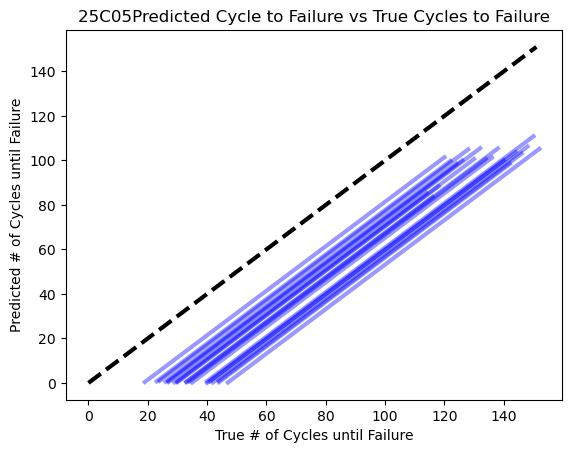

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 62.87073813719985
The True RuL at Cycle 10 is: 112


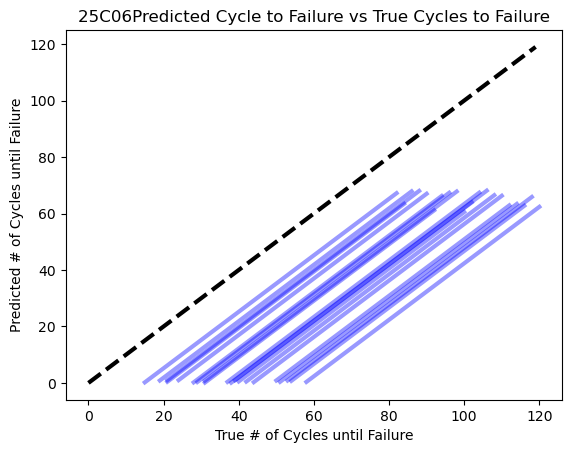

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 58.81396685454229
The True RuL at Cycle 10 is: 24


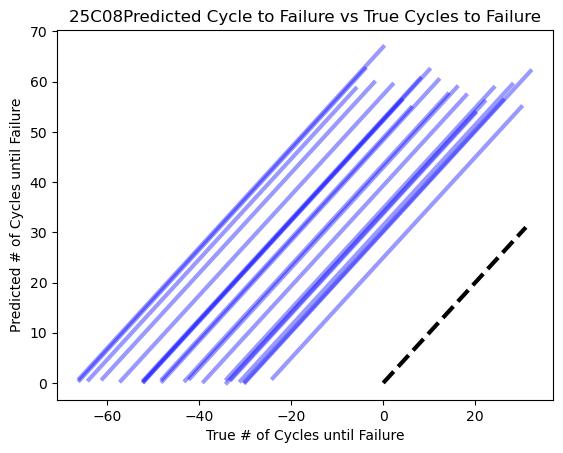

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 222.85412844669736
The True RuL at Cycle 10 is: 254


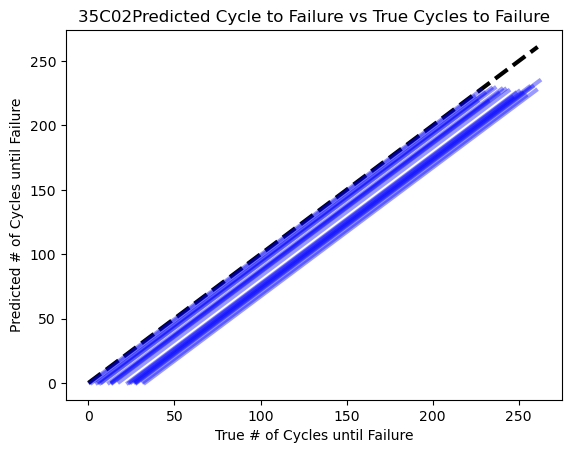

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 378.4369532970409
The True RuL at Cycle 10 is: 380


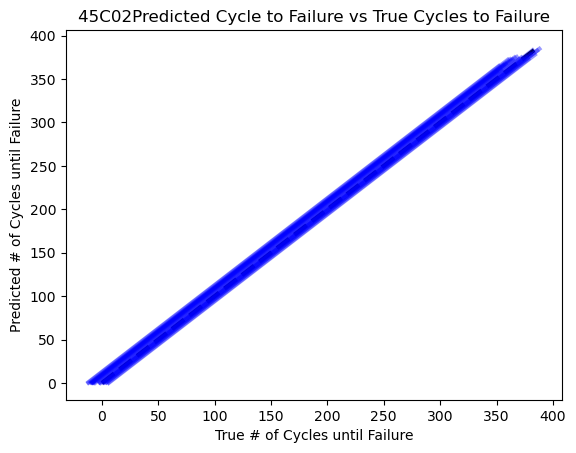

In [10]:
for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

[[60 10]
 [19 31]]
{'25C01': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], '25C02': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C03': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C04': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C05': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], '25C06': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C07': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C08': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '35C01': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '35C02': [0.0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '45C01': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], '45C02': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]}


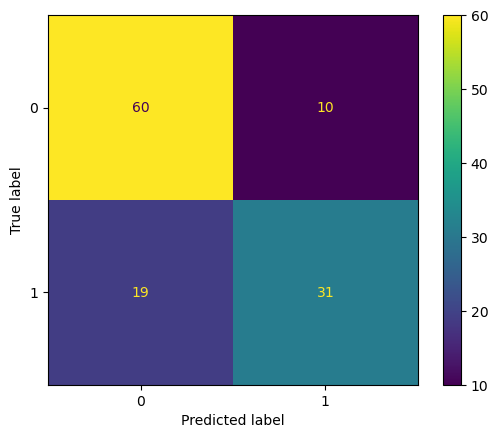

In [112]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=15, random_state=121)
true_c=[]
pred_c=[]
p_dict={}
train_Lst = ['25C01','25C02','25C03','25C04','25C05','25C06','25C07','25C08','35C01','35C02','45C01','45C02']
for bat1 in train_Lst:
    train_Lst = ['25C01','25C02','25C03','25C04','25C05','25C06','25C07','25C08','35C01','35C02','45C01','45C02']
    test_Lst = [bat1]
    for battery in test_Lst:
        train_Lst.remove(battery)
    tc,pc,tmdl=run_Classification_ML(Scaled_EIS,train_Lst,test_Lst,my_feats,model)
    p_dict[bat1]=[mode(pc),pc]
    for x in tc:
        true_c.append(x)
    for y in pc:
        pred_c.append(y)

cm=confusion_matrix(true_c,pred_c)
print(cm)
print(p_dict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

[[40  0]
 [ 0 20]]


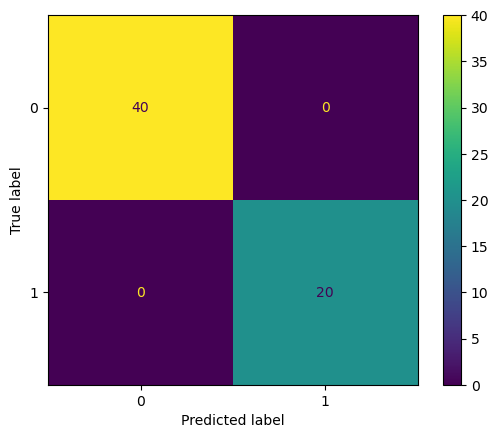

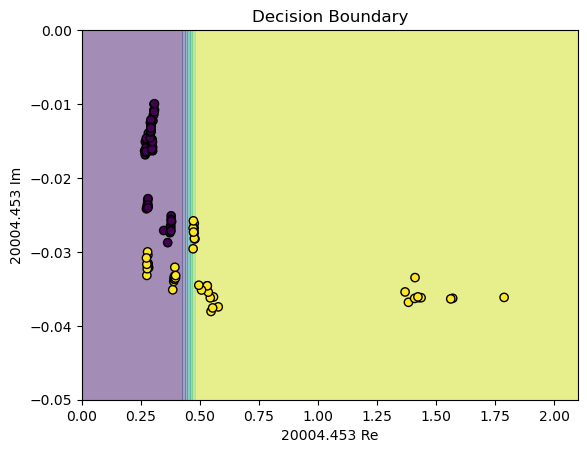

[[ 5.62395 -1.32345]]


In [12]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=5, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=50)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[69  1]
 [ 0 50]]


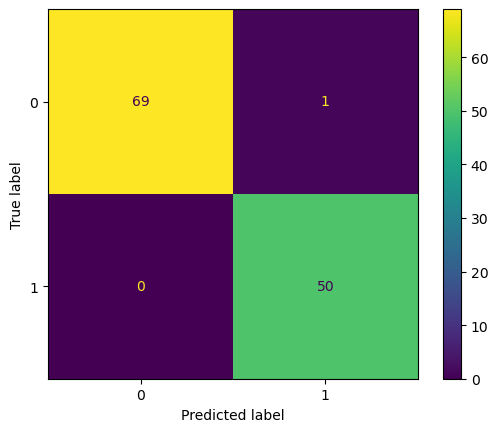

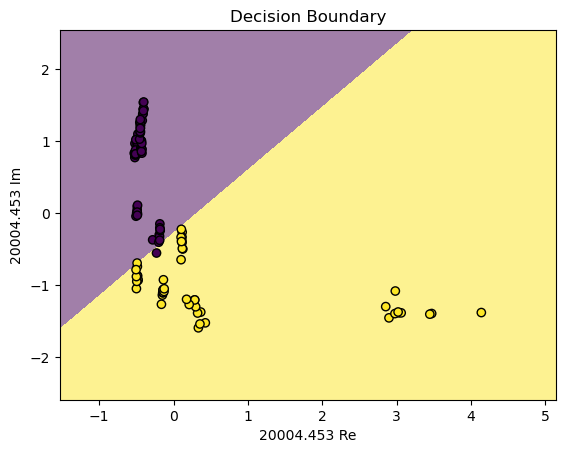

[[ 17.04689094 -19.45981122]]
[-5.16581355]


In [115]:
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=40000, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(Scaled_EIS,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = Scaled_EIS[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = Scaled_EIS['category']
#print(X_Total)
#disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=50)
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=4000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)
print(tmdl.intercept_)

[[70  0]
 [ 0 50]]


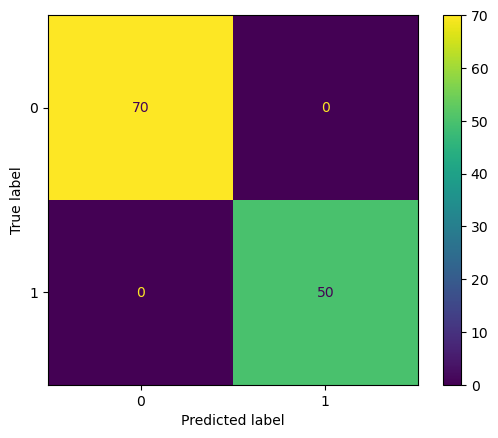

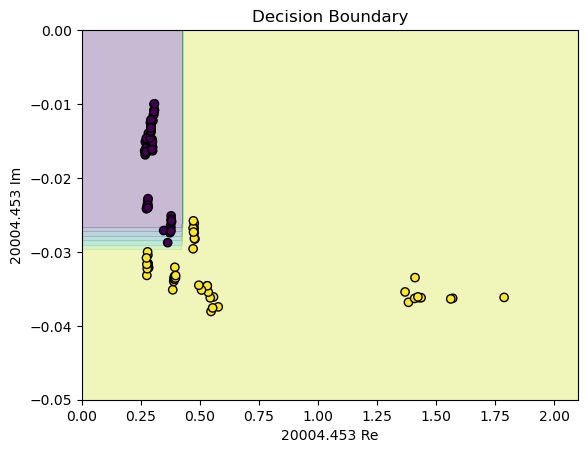

In [116]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=DecisionTreeClassifier(criterion='gini',max_depth=5)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.3,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[36  4]
 [ 4 16]]


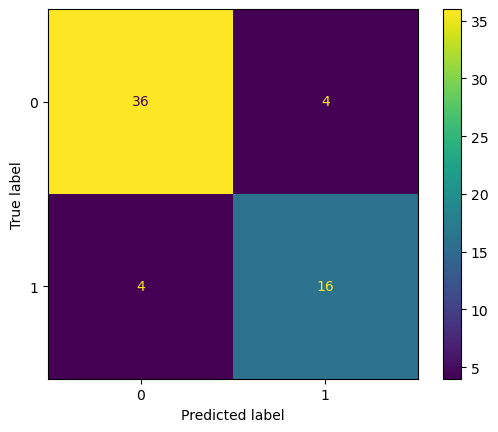

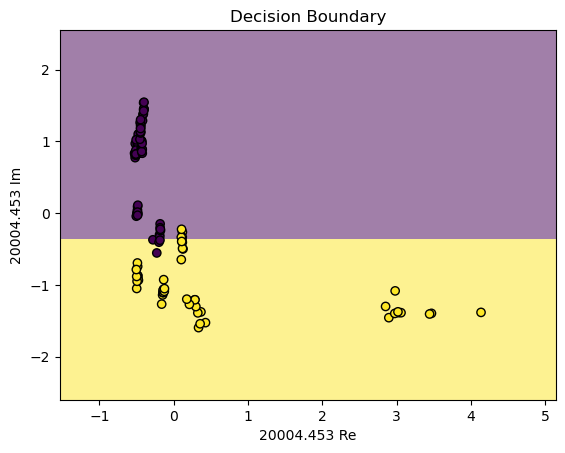

In [119]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=DecisionTreeClassifier(criterion='gini',max_depth=2)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(Scaled_EIS,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = Scaled_EIS[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = Scaled_EIS['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[70  0]
 [ 0 50]]


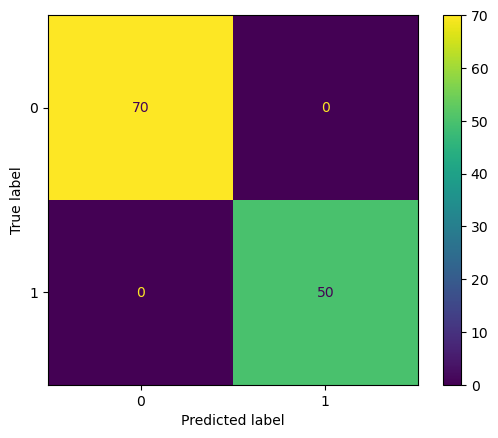

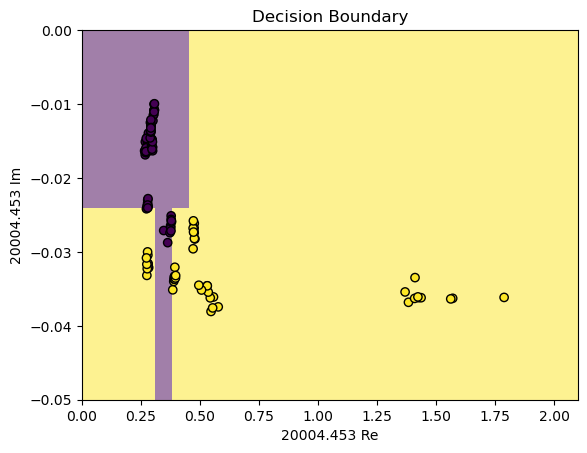

In [23]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=50)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[70  0]
 [ 0 50]]


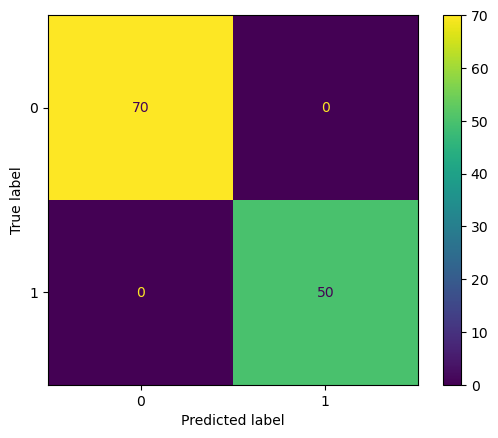

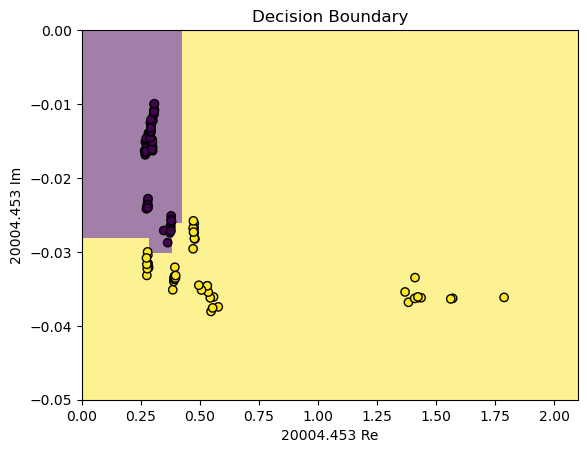

In [24]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=3, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


In [ ]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=3, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[60 10]
 [ 0 50]]


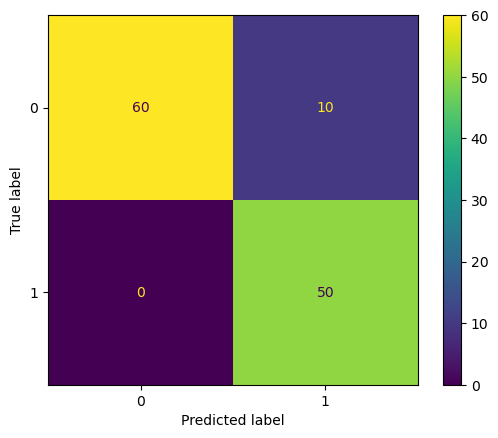

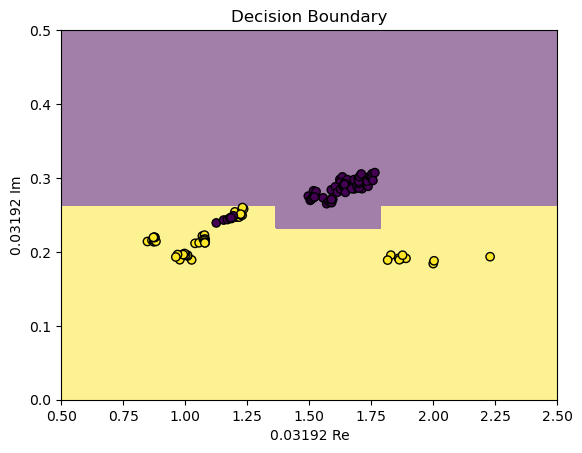

In [35]:
my_feats=['0.03192 Re','0.03192 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=2, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0.5,2.5)
plt.ylim(0.0,0.5)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[36  4]
 [ 4 16]]


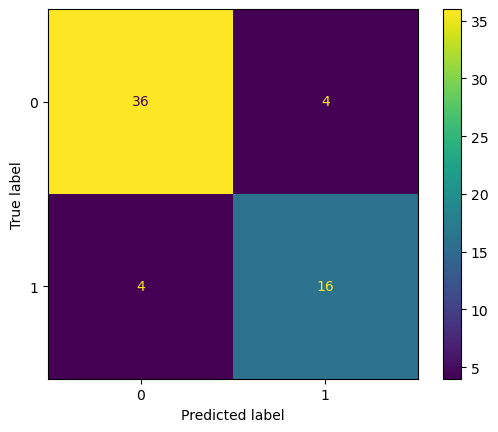

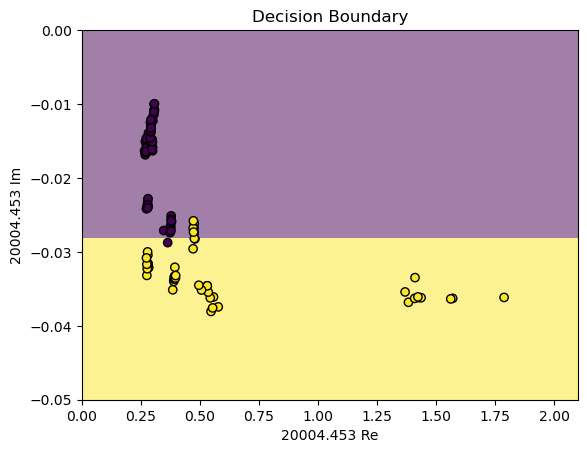

In [26]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[30 10]
 [ 0 20]]


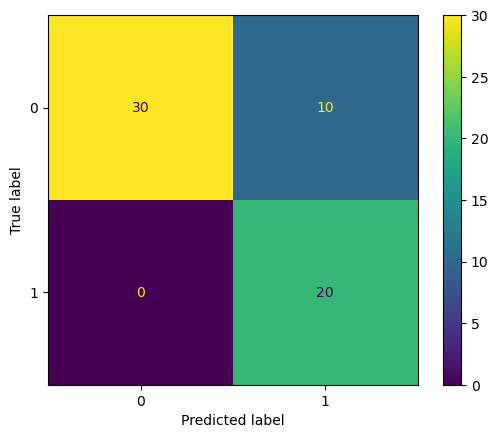

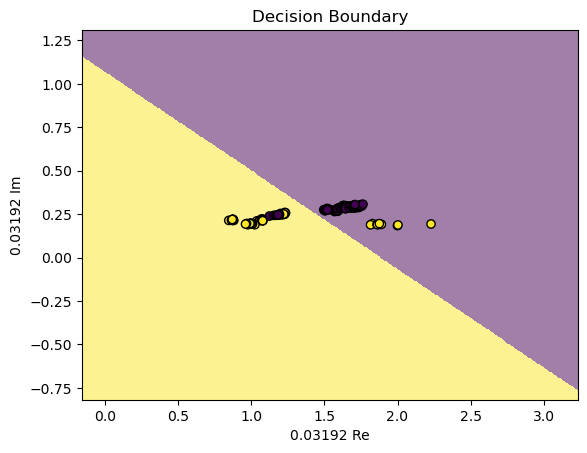

[[-3.38235 -5.9637 ]]


In [31]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['0.03192 Re','0.03192 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[30 10]
 [ 0 20]]


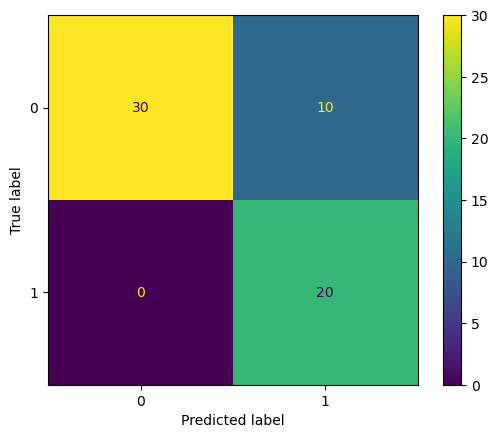

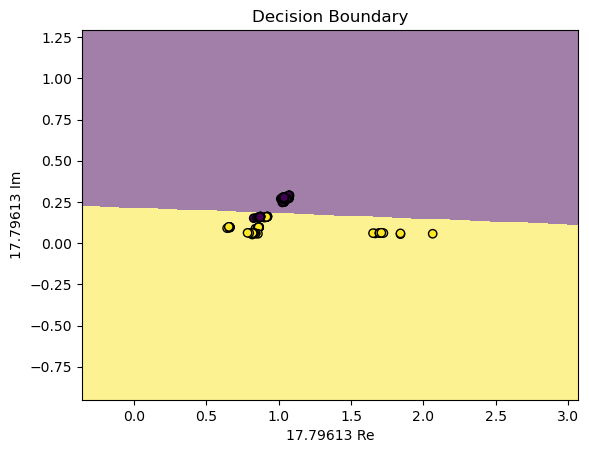

[[ -0.3500936 -10.5162886]]


In [30]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['17.79613 Re','17.79613 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[30 10]
 [ 0 20]]


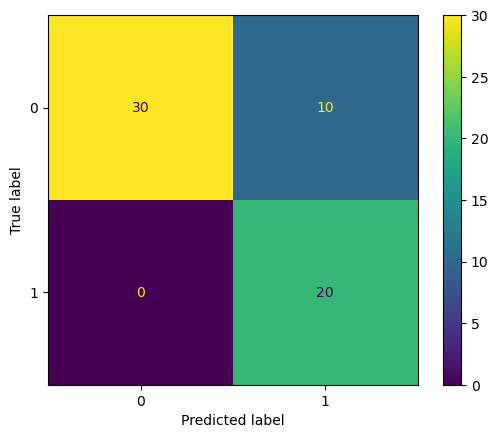

In [211]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['2.16054 Re','2.16054 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

[[30 10]
 [ 0 20]]


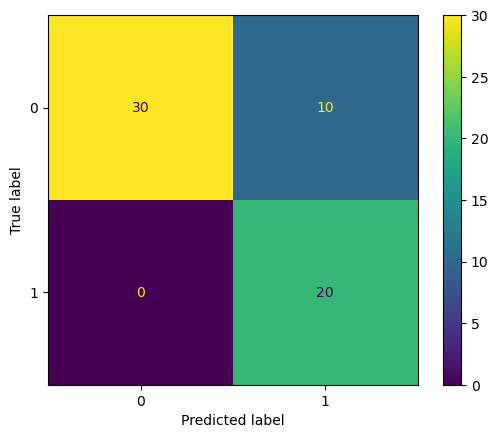

In [16]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['EIS_PCA_1','EIS_PCA_2']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

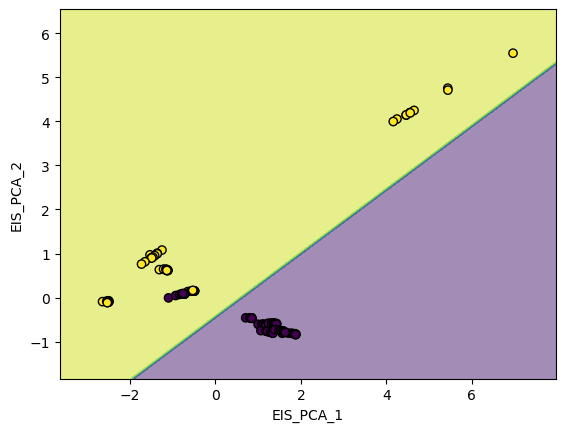

In [17]:
X = df_20[my_feats]
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",alpha=0.5)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.show()

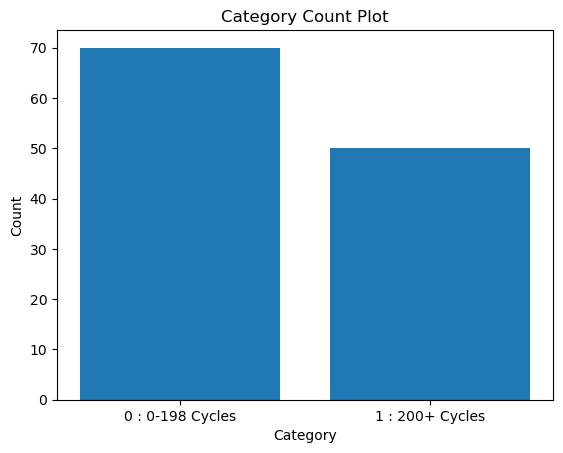

In [40]:
#For classification, category should be relatively balanced. 
#We balance the data by taking only the first 20 cycles for every battery. 
counts=df_20['category'].value_counts()
plt.bar(['0 : 0-198 Cycles','1 : 200+ Cycles'],[counts[0],counts[1]])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Count Plot')
plt.show()

In [41]:
#Function to display a plot quickly.
def plot_CF(mydf,col1,col2):
    plt.scatter(mydf[col1],mydf[col2],c=mydf['category'])
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(col1+' vs. '+col2)
    plt.show()